In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy.io import fits
import os
#spectrum_class.py NEEDS TO BE IN THE SAME FOLDER AS THIS FILE TO WORK
import spectrum_class    

poss_air_coeffs = {'edlen_1953':[6.4328e-5, 2.94981e-2, 2.5540e-4, 146.0, 41.0],
                   'edlen_1966':[8.34213e-5, 2.406030e-2, 1.5997e-4, 130.0, 38.9],
                   'peak_and_reeder_1972':[0.0, 5.791817e-2, 1.67909e-3, 238.0185, 57.362],
                   'ciddor_1996':[0.0, 5.792105e-2, 1.67917e-3, 238.0185, 57.362]}
air_coeffs = poss_air_coeffs['ciddor_1996']



#matplotlib.rc('text',usetex=True)
font = {'family' : 'serif',
#        'weight' : 'bold',
        'size'   : 16,}
matplotlib.rc('font', **font)


pypeit_chipgap = []
spec2d_chipgap = []
pypeit_snr_blue = []
pypeit_snr_red = []
spec2d_snr_blue = []
spec2d_snr_red = []
all_target_name = []

mask = 'hgc1a'
detector = ['det26','det37','det48']
#finding spec1d files in pypeit reduction
for n in range(1,8):
    pypeit_path = f'/Volumes/Jiamu4/2020feb26_pypeit_red/hgc{n}a/coadd1d_results/'
    possible_paths = [os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(pypeit_path)) for f in fn]
    pypeit_fits = []
    target_name = []
    for fit_file in possible_paths:
        if ('G_' in fit_file) and ('_coadd1d.fits' in fit_file):
            pypeit_fits.append(fit_file)
    for i in range(len(pypeit_fits)):
        name = (pypeit_fits[i].split('coadd1d_results/')[1]).split('_coadd1d.fits')[0]
        target_name.append(name)
    #print(f'Total number of pypeit files: {len(target_name)}')
    all_target_name.append(target_name)
    pypeit_file = f'{target_name}_coadd1d.fits'

    #read in pypeit results
    for star in range(len(target_name)):
        pypeit_file = f'{target_name[star]}_coadd1d.fits'
        #print(pypeit_path + pypeit_file)
        pypeit = fits.open(pypeit_path + pypeit_file)

        wave = pypeit[1].data['wave']
        wave = wave/((air_coeffs[0] + \
                                 air_coeffs[1]/(air_coeffs[3]-np.power(wave,-2)) + \
                                 air_coeffs[2]/(air_coeffs[4]-np.power(wave,-2))) + 1)
        flux = pypeit[1].data['flux']
        ivar = pypeit[1].data['ivar']

    #print(target_name,pypeit_chipgap)

    #     break

    #     #print(pypeit)
        #sky = pypeit[1].data['telluric']

        #read in spec2d files
        #mask_name = 'hgc1a'
        spec2dpath = f'/Volumes/Jiamu4/2020feb26_spec2d_red/hgc{n}a/'
        filepath = ''
        for file in os.listdir(spec2dpath):
            if ('spec1d' in file) and ('zspec' not in file) and ('.fits' in file) and (target_name[star] in file):
                filepath = f'{spec2dpath}{file}'
                break
        if filepath == '':
    #         raise ValueError(f'Could not find matching spec2d file for target {target_name[star]} on mask {mask_name}.')
            print(f'WARNING: Could not find matching spec2d file for target {target_name[star]} on mask {mask_name}.')
            continue
        spec = spectrum_class.simple_Spectrum(filepath)

        spec2d_wave = spec.lam
        spec2d_flux = spec.flux
        spec2d_ivar = spec.ivar

        spec2d_sky = spec.sky

        wave_bounds = 7000,7500
        pypeit_region = (wave > wave_bounds[0]) & (wave < wave_bounds[1])
        pypeit_norm = np.median(flux[pypeit_region])
        flux = flux/pypeit_norm
        ivar = ivar*pypeit_norm**2

        spec2d_region = (spec2d_wave > wave_bounds[0]) & (spec2d_wave < wave_bounds[1])
        spec2d_norm = np.median(spec2d_flux[spec2d_region])
        spec2d_flux = spec2d_flux/spec2d_norm
        spec2d_ivar = spec2d_ivar*spec2d_norm**2

        flux_err = 1/np.sqrt(ivar)
        spec2d_flux_err = 1/np.sqrt(spec2d_ivar)

        chip_gap_ind = np.argmax(np.diff(wave))

        chip_gap_waves = wave[[chip_gap_ind,chip_gap_ind+1]]
        chip_gap_mask = 10
        gap_wave_dist = 20+chip_gap_mask

        near_blue_gap = (wave <= chip_gap_waves[0]+chip_gap_mask) & (wave >= chip_gap_waves[0]-gap_wave_dist)
        near_red_gap = (wave >= chip_gap_waves[1]-chip_gap_mask) & (wave <= chip_gap_waves[1]+gap_wave_dist)
        
        blue_gap_coeff = np.polyfit(wave[near_blue_gap],flux[near_blue_gap],deg=1,w=np.sqrt(ivar[near_blue_gap]))
        red_gap_coeff = np.polyfit(wave[near_red_gap],flux[near_red_gap],deg=1,w=np.sqrt(ivar[near_red_gap]))

#         med_blue_gap = np.median(flux[near_blue_gap])
#         med_red_gap = np.median(flux[near_red_gap])
        chip_gap_wave = np.average(chip_gap_waves)
        chip_gap_fitx = np.linspace(chip_gap_waves[0]-gap_wave_dist,chip_gap_waves[1]+gap_wave_dist,200)
        med_blue_gap = np.poly1d(blue_gap_coeff)(chip_gap_wave)
        med_red_gap = np.poly1d(red_gap_coeff)(chip_gap_wave)
        pypeit_gap_diff = med_blue_gap - med_red_gap
        blue_gap_fity = np.poly1d(blue_gap_coeff)(chip_gap_fitx)
        red_gap_fity = np.poly1d(red_gap_coeff)(chip_gap_fitx)
    

        spec2d_chip_gap_ind = np.argmax(np.diff(spec2d_wave))

        spec2d_chip_gap_waves = spec2d_wave[[spec2d_chip_gap_ind,spec2d_chip_gap_ind+1]]
        #spec2d_gap_wave_dist = 100

        spec2d_near_blue_gap = (spec2d_wave <= chip_gap_waves[0]-5) & (spec2d_wave >= spec2d_chip_gap_waves[0]-gap_wave_dist)
        spec2d_near_red_gap = (spec2d_wave >= chip_gap_waves[1]+5) & (spec2d_wave <= spec2d_chip_gap_waves[1]+gap_wave_dist)

#         spec2d_med_blue_gap = np.median(spec2d_flux[spec2d_near_blue_gap])
#         spec2d_med_red_gap = np.median(spec2d_flux[spec2d_near_red_gap])
        
        spec2d_blue_gap_coeff = np.polyfit(spec2d_wave[spec2d_near_blue_gap],spec2d_flux[spec2d_near_blue_gap],
                                           deg=1,w=np.sqrt(spec2d_ivar[spec2d_near_blue_gap]))
        spec2d_red_gap_coeff = np.polyfit(spec2d_wave[spec2d_near_red_gap],spec2d_flux[spec2d_near_red_gap],
                                          deg=1,w=np.sqrt(spec2d_ivar[spec2d_near_red_gap]))
        spec2d_med_blue_gap = np.poly1d(spec2d_blue_gap_coeff)(chip_gap_wave)
        spec2d_med_red_gap = np.poly1d(spec2d_red_gap_coeff)(chip_gap_wave)
        spec2d_gap_diff = spec2d_med_blue_gap - spec2d_med_red_gap
        spec2d_blue_gap_fity = np.poly1d(spec2d_blue_gap_coeff)(chip_gap_fitx)
        spec2d_red_gap_fity = np.poly1d(spec2d_red_gap_coeff)(chip_gap_fitx)

        #pypeit_chipgap.append(med_blue_gap-med_red_gap)

        ## plot chipgap
        #plt.figure(figsize=(16,8))
        #plt.axvline(chip_gap_waves[0],c='r',lw=2,ls='--')
        #plt.axvline(chip_gap_waves[1],c='r',lw=2,ls='--')
        #print('pypeit chipgap = ',pypeit_gap_diff, ';spec2d chipgap = ', spec2d_gap_diff)
        #plt.scatter(chip_gap_wave,med_blue_gap)
        #plt.scatter(chip_gap_wave,med_red_gap)
        #plt.plot(chip_gap_fitx,spec2d_blue_gap_fity,c='b',ls='--')
        #plt.plot(chip_gap_fitx,spec2d_red_gap_fity,c='r',ls='--')
        #plt.plot(chip_gap_fitx,blue_gap_fity,c='b')
        #plt.plot(chip_gap_fitx,red_gap_fity,c='r')
#         xlim = plt.xlim()
#         ylim = plt.ylim()
        
#         plt.plot(wave,flux,zorder=-10000)
#         plt.plot(spec2d_wave,spec2d_flux,zorder=-1000)

#         plt.xlim(xlim);plt.ylim(ylim)
#         plt.show()

        #pypeit SNR
        snr_per_pix = flux*np.sqrt(ivar)
        snr_window_blue = 5500,6500
        snr_window_red = 8000,9000
        snr_region_blue = (wave > snr_window_blue[0]) & (wave < snr_window_blue[1])
        med_snr_blue = np.median(snr_per_pix[snr_region_blue])
        snr_region_red = (wave > snr_window_red[0]) & (wave < snr_window_red[1])
        med_snr_red = np.median(snr_per_pix[snr_region_red])
        #spec2d SNR
        spec2d_snr_per_pix = spec2d_flux*np.sqrt(spec2d_ivar)
        spec2d_snr_region_blue = (spec2d_wave > snr_window_blue[0]) & (spec2d_wave < snr_window_blue[1])
        spec2d_med_snr_blue = np.median(spec2d_snr_per_pix[spec2d_snr_region_blue])
        spec2d_snr_region_red = (spec2d_wave > snr_window_red[0]) & (spec2d_wave < snr_window_red[1])
        spec2d_med_snr_red = np.median(spec2d_snr_per_pix[spec2d_snr_region_red])

        #plot SNR
#         plt.figure(figsize=(15,5))
#         plt.plot(wave,snr_per_pix)
#         plt.plot(spec2d_wave,spec2d_snr_per_pix)
#         plt.axvline(snr_window_blue[0],c='r',lw=2,ls='--')
#         plt.axvline(snr_window_blue[1],c='r',lw=2,ls='--')
#         plt.plot([snr_window_blue[0],snr_window_blue[1]],[med_snr_blue,med_snr_blue],c='r')
#         plt.plot([snr_window_blue[0],snr_window_blue[1]],[spec2d_med_snr_blue,spec2d_med_snr_blue],c='g')
#         plt.axvline(snr_window_red[0],c='r',lw=2,ls='--')
#         plt.axvline(snr_window_red[1],c='r',lw=2,ls='--')
#         plt.plot([snr_window_red[0],snr_window_red[1]],[med_snr_red,med_snr_red],c='r')
#         plt.plot([snr_window_red[0],snr_window_red[1]],[spec2d_med_snr_red,spec2d_med_snr_red],c='g')
        plt.show()
        pypeit_chipgap.append(pypeit_gap_diff)
        spec2d_chipgap.append(spec2d_gap_diff)
        pypeit_snr_blue.append(med_snr_blue)
        pypeit_snr_red.append(med_snr_red)
        spec2d_snr_blue.append(spec2d_med_snr_blue)
        spec2d_snr_red.append(spec2d_med_snr_red)

#print(target_name,pypeit_chipgap)
    #break

#     #plot both and label the points
#     plt.figure(figsize=[12,8])
# #     plt.errorbar(wave,flux,yerr=flux_err,fmt='o',color='C0',
# #                  ms=1,alpha=0.85,label='PypeIt Result')
# #     plt.errorbar(spec2d_wave,spec2d_flux,yerr=spec2d_flux_err,
# #                  fmt='o',color='C1',ms=1,alpha=0.85,label='spec2d Result')
        
#     plt.plot(wave,flux/flux_err,label='PypeIt')
#     plt.plot(spec2d_wave,spec2d_flux/spec2d_flux_err,label='Spec2d')
    
    
# #     plt.xlim(5000-100,5000+100)
#     #plt.ylim(-0.1,)
#     plt.xlabel('wavelength')
#     plt.ylabel('SNR')
#     plt.legend(loc='best',markerscale=5)
#     plt.title(f'{target_name[star]}_SNR')
#     plt.tight_layout()
#     savepath = f'/Users/huangjiamu/Desktop/HALO7D/Comparison/SNR/{mask}/'
#     plt.savefig(f'{savepath}{target_name[star]}_SNR.png', dpi=None, facecolor='w', edgecolor='w',\
#         orientation='portrait', format=None,\
#         transparent=False, bbox_inches=None, pad_inches=0.1)
#     plt.show();

/Users/huangjiamu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: divide by zero encountered in true_divide


In [2]:
print(len(pypeit_chipgap))
# print(spec2d_chipgap)
# print(pypeit_snr_blue)
# print(pypeit_snr_red)
# print(spec2d_snr_blue)
# print(spec2d_snr_red)

181


In [3]:
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl

halo7d_ext_gaia_phot_file = '/Users/huangjiamu/Desktop/HALO7D/HALO7D_Gaia_possible_targets_photometry.dat'
with open(halo7d_ext_gaia_phot_file,'r') as f:
    lines = f.readlines()
possible_gaia_targs = {'target':[],'ra':[],'dec':[],'g_mag':[],'b_mag':[],'r_mag':[]}
for line in lines:
    line = line.strip().split()
    #print(line)
    if len(line) < 0:
        continue
    targ,ra,dec,gmag,bmag,rmag = line
    if 'G_' not in targ:
        continue
    coords = SkyCoord(ra=ra,dec=dec,unit=(u.hourangle,u.deg))
    ra = coords.ra.value
    dec = coords.dec.value
    try:
        gmag = float(gmag)
    except:
        gmag = np.nan
    try:
        bmag = float(bmag)
    except:
        bmag = np.nan
    try:
        rmag = float(rmag)
    except:
        rmag = np.nan
    possible_gaia_targs['target'].append(targ)
    possible_gaia_targs['ra'].append(ra)
    possible_gaia_targs['dec'].append(dec)
    possible_gaia_targs['g_mag'].append(gmag)
    possible_gaia_targs['b_mag'].append(bmag)
    possible_gaia_targs['r_mag'].append(rmag)
for param in possible_gaia_targs:
    possible_gaia_targs[param] = np.array(possible_gaia_targs[param])

In [4]:
#all_target_name
all_target_names = list(np.concatenate(all_target_name).flat)

In [5]:
select = {'sel_target':[],'sel_ra':[],'sel_dec':[],'sel_bmag':[],'sel_rmag':[],'sel_gmag':[]}
for i in all_target_names:
    match = np.where(possible_gaia_targs['target'] == i)[0]
    select['sel_target'].append(possible_gaia_targs['target'][match])
    select['sel_ra'].append(possible_gaia_targs['ra'][match])
    select['sel_dec'].append(possible_gaia_targs['dec'][match])
    select['sel_gmag'].append(possible_gaia_targs['g_mag'][match])
    select['sel_bmag'].append(possible_gaia_targs['b_mag'][match])
    select['sel_rmag'].append(possible_gaia_targs['r_mag'][match])
bmag = np.array(select['sel_bmag'])
rmag = np.array(select['sel_rmag'])
gmag = np.array(select['sel_gmag'])

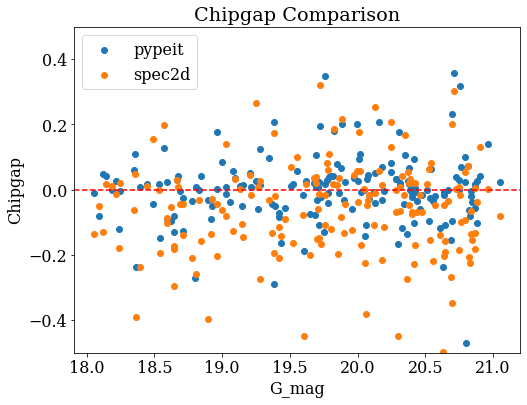

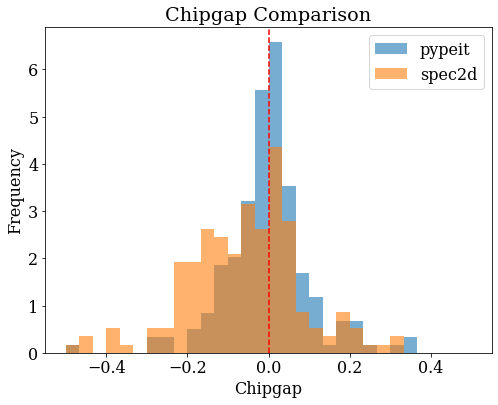

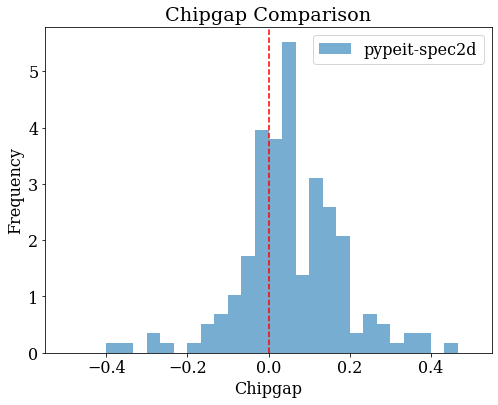

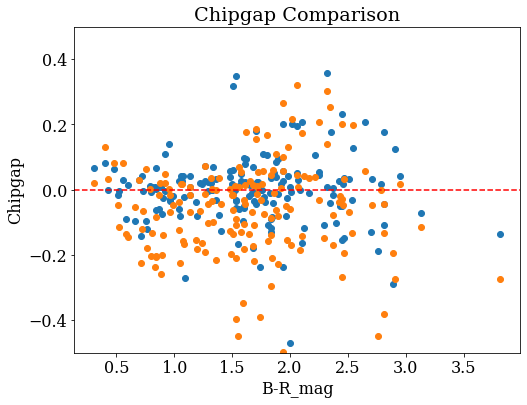

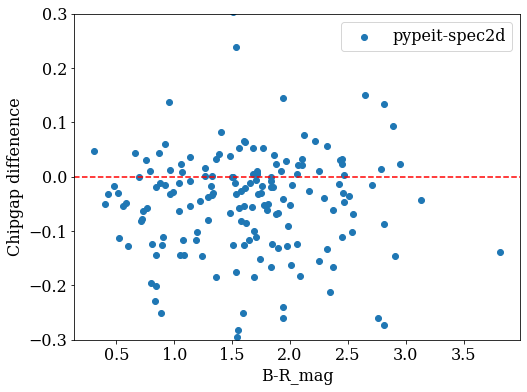

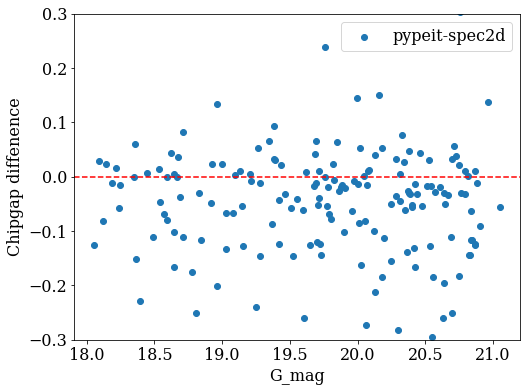

In [7]:
#matplotlib.rc('text',usetex=True)
font = {'family' : 'serif',
#        'weight' : 'bold',
        'size'   : 16,}
matplotlib.rc('font', **font)
plt.figure(figsize=(8,6))
plt.ylim(-0.5,0.5)
plt.title('Chipgap Comparison')
plt.xlabel('G_mag')
plt.ylabel('Chipgap')
plt.scatter(select['sel_gmag'],pypeit_chipgap,label='pypeit')
plt.scatter(select['sel_gmag'],spec2d_chipgap,label='spec2d')
plt.axhline(y=0, color='r', linestyle='--')
plt.legend()

plt.figure(figsize=(8,6))
plt.title('Chipgap Comparison')
plt.xlabel('Chipgap')
plt.ylabel('Frequency')
plt.hist(pypeit_chipgap,range=[-0.5, 0.5],density=True,alpha=0.6,bins=30,label='pypeit')
plt.hist(spec2d_chipgap,range=[-0.5, 0.5],density=True,alpha=0.6,bins=30,label='spec2d')
plt.axvline(x=0, color='r', linestyle='--')
plt.legend()
plt.savefig(f'Chipgap_hist.png', dpi=300, facecolor='w', edgecolor='w',\
        orientation='portrait', format=None,\
        transparent=False, bbox_inches=None, pad_inches=0.1)
plt.show()

plt.figure(figsize=(8,6))
plt.title('Chipgap Comparison')
plt.xlabel('Chipgap')
plt.ylabel('Frequency')
plt.hist(np.array(pypeit_chipgap)-np.array(spec2d_chipgap)
         ,range=[-0.5, 0.5],density=True,alpha=0.6,bins=30,label='pypeit-spec2d')
plt.axvline(x=0, color='r', linestyle='--')
plt.legend()

plt.figure(figsize=(8,6))
plt.ylim(-0.5,0.5)
plt.title('Chipgap Comparison')
plt.xlabel('B-R_mag')
plt.ylabel('Chipgap')
plt.scatter(bmag-rmag,pypeit_chipgap,label='pypeit')
plt.scatter(bmag-rmag,spec2d_chipgap,label='spec2d')
plt.axhline(y=0, color='r', linestyle='--')

plt.figure(figsize=(8,6))
plt.scatter(bmag-rmag,np.abs(pypeit_chipgap)-np.abs(spec2d_chipgap),label='pypeit-spec2d')
plt.axhline(y=0, color='r', linestyle='--')
plt.ylim(-0.3,0.3)
plt.xlabel('B-R_mag')
plt.ylabel('Chipgap diffenence')
plt.legend()
plt.figure(figsize=(8,6))
plt.scatter(select['sel_gmag'],np.abs(pypeit_chipgap)-np.abs(spec2d_chipgap),label='pypeit-spec2d')
plt.ylim(-0.3,0.3)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('G_mag')
plt.ylabel('Chipgap diffenence')
plt.legend()

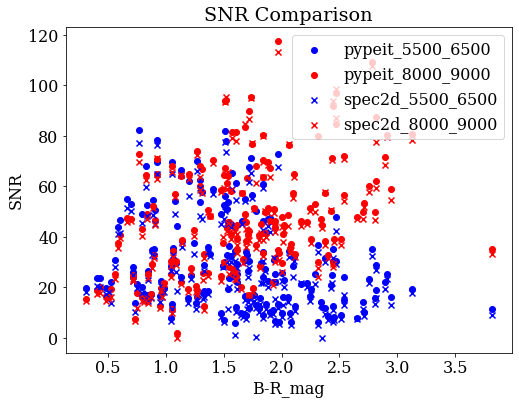

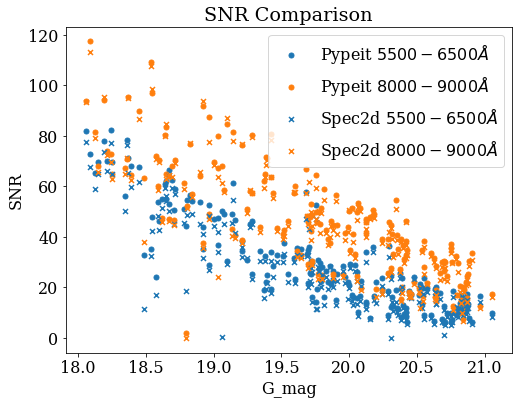

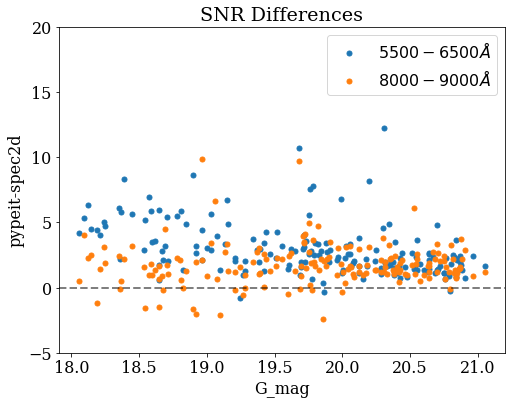

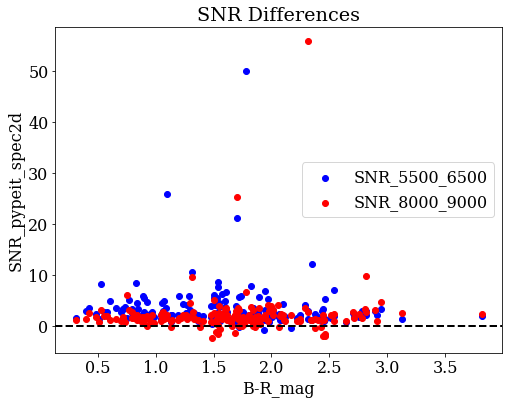

In [36]:
plt.figure(figsize=(8,6))
#plt.ylim(-0.1,0.6)
plt.title('SNR Comparison')
plt.xlabel('B-R_mag')
plt.ylabel('SNR')
plt.scatter(bmag-rmag,np.abs(pypeit_snr_blue),color='b',label='pypeit_5500_6500')
plt.scatter(bmag-rmag,np.abs(pypeit_snr_red),color='r',label='pypeit_8000_9000')
plt.scatter(bmag-rmag,np.abs(spec2d_snr_blue),marker='x',color='b',label='spec2d_5500_6500')
plt.scatter(bmag-rmag,np.abs(spec2d_snr_red),marker='x',color='r',label='spec2d_8000_9000')
plt.legend()

plt.figure(figsize=(8,6))
#plt.ylim(-0.1,0.6)
plt.title('SNR Comparison')
plt.xlabel('G_mag')
plt.ylabel('SNR')
plt.scatter(gmag,np.abs(pypeit_snr_blue),label=r'Pypeit $5500-6500\AA$',s=25)
plt.scatter(gmag,np.abs(pypeit_snr_red),label=r'Pypeit $8000-9000\AA$',s=25)
plt.scatter(gmag,np.abs(spec2d_snr_blue),marker='x',color='C0',label=r'Spec2d $5500-6500\AA$',s=25)
plt.scatter(gmag,np.abs(spec2d_snr_red),marker='x',color='C1',label=r'Spec2d $8000-9000\AA$',s=25)
plt.legend()
plt.savefig(f'SNR.png', dpi=300, facecolor='w', edgecolor='w',\
        orientation='portrait', format=None,\
        transparent=False, bbox_inches=None, pad_inches=0.1)
plt.show()

plt.figure(figsize=(8,6))
plt.title('SNR Differences')
plt.xlabel('G_mag')
plt.ylabel('pypeit-spec2d')
plt.scatter(gmag,np.abs(pypeit_snr_blue)-np.abs(spec2d_snr_blue),label=r'$5500-6500\AA$',s=25)
plt.scatter(gmag,np.abs(pypeit_snr_red)-np.abs(spec2d_snr_red),label=r'$8000-9000\AA$',s=25)
plt.axhline(y=0,linewidth=2,color = 'k',linestyle='--',alpha=0.5)
plt.ylim(-5,20)
plt.legend()
plt.savefig(f'SNR_diff.png', dpi=300, facecolor='w', edgecolor='w',\
        orientation='portrait', format=None,\
        transparent=False, bbox_inches=None, pad_inches=0.1)
plt.show()

plt.figure(figsize=(8,6))
plt.title('SNR Differences')
plt.xlabel('B-R_mag')
plt.ylabel('SNR_pypeit_spec2d')
plt.scatter(bmag-rmag,np.abs(pypeit_snr_blue)-np.abs(spec2d_snr_blue),color='b',label='SNR_5500_6500')
plt.scatter(bmag-rmag,np.abs(pypeit_snr_red)-np.abs(spec2d_snr_red),color='r',label='SNR_8000_9000')
plt.axhline(y=0,linewidth=2,color = 'k',linestyle='--')
plt.legend()

In [ ]:
savepath = f'/Users/huangjiamu/Desktop/HALO7D/Comparison/'
plt.figure(figsize=(8,6))
plt.ylim(0.5,2.6)
plt.title('SNR Comparison')
plt.xlabel('B-R_mag')
plt.ylabel('log SNR')
plt.scatter(bmag-rmag,np.log10(pypeit_snr_blue),color='b',label='pypeit_5500_6500')
plt.scatter(bmag-rmag,np.log10(pypeit_snr_red),color='r',label='pypeit_8000_9000')
plt.scatter(bmag-rmag,np.log10(spec2d_snr_blue),marker='x',color='b',label='spec2d_5500_6500')
plt.scatter(bmag-rmag,np.log10(spec2d_snr_red),marker='x',color='r',label='spec2d_8000_9000')
plt.legend()
# plt.savefig(f'{savepath}SNR_b-r.png', dpi=300, facecolor='w', edgecolor='w',\
#         orientation='portrait', format=None,\
#         transparent=False, bbox_inches=None, pad_inches=0.1)
plt.show();

plt.figure(figsize=(8,6))
plt.ylim(0.5,2.6)
plt.title('SNR Comparison')
plt.xlabel('G_mag')
plt.ylabel('log SNR')
plt.scatter(gmag,np.log10(pypeit_snr_blue),color='b',label='pypeit_5500_6500')
plt.scatter(gmag,np.log10(pypeit_snr_red),color='r',label='pypeit_8000_9000')
plt.scatter(gmag,np.log10(spec2d_snr_blue),marker='x',color='b',label='spec2d_5500_6500')
plt.scatter(gmag,np.log10(spec2d_snr_red),marker='x',color='r',label='spec2d_8000_9000')
plt.legend()
# plt.savefig(f'{savepath}SNR_g.png', dpi=300, facecolor='w', edgecolor='w',\
#         orientation='portrait', format=None,\
#         transparent=False, bbox_inches=None, pad_inches=0.1)
plt.show();

In [ ]:
##Plotting SNR_diff vs SNR
## also in log scale